# Multilayer Perceptron

An MLP is an Artificial Neural Network (ANN) with a single hidden layer of the following graphical representation:
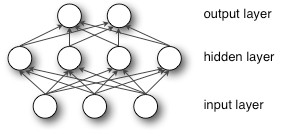
Hidden layer function -> \begin{equation}f(x) = G( b^{(2)} + W^{(2)}( s( b^{(1)} + W^{(1)} x)))\end{equation}

In [1]:
"""
This tutorial introduces the multilayer perceptron using Theano.

 A multilayer perceptron is a logistic regressor where
instead of feeding the input to the logistic regression you insert a
intermediate layer, called the hidden layer, that has a nonlinear
activation function (usually tanh or sigmoid) . One can use many such
hidden layers making the architecture deep. The tutorial will also tackle
the problem of MNIST digit classification.

.. math::

    f(x) = G( b^{(2)} + W^{(2)}( s( b^{(1)} + W^{(1)} x))),

References:

    - textbooks: "Pattern Recognition and Machine Learning" -
                 Christopher M. Bishop, section 5

"""

from __future__ import print_function

__docformat__ = 'restructedtext en'


import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T


from logistic_sgd import LogisticRegression, load_data

In [6]:
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function
        # the output of uniform if converted using asarray to dtype
        # theano.config.floatX so that the code is runable on GPU
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        
        low_bound = -numpy.sqrt(6. / (n_in + n_out))
        high_bound = numpy.sqrt(6. / (n_in + n_out))
        size = (n_in, n_out)                                     # size of matrix
        rand_matrix = rng.uniform(low_bound, high_bound, size)   # matrix of random numbers for our weights
        
        if W is None:
            W_values = numpy.asarray(rand_matrix, dtype=theano.config.floatX)
            
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        
        # parameters of the model
        self.params =[self.W, self.b]

In [7]:
class MLP(object):
    """
    Multi-Layer Perceptron Class

    A multilayer perceptron is a feedforward artificial neural network model
    that has one layer or more of hidden units and nonlinear activations.
    Intermediate layers usually have as activation function tanh or the
    sigmoid function (defined here by a ``HiddenLayer`` class)  while the
    top layer is a softmax layer (defined here by a ``LogisticRegression``
    class).
    """

    def __init__(self, rng, input, n_in, n_hidden, n_out):
        """
        Initialize the parameters for the multilayer perceptron

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
        architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
        which the datapoints lie

        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
        which the labels lie

        """

        # Since we are dealing with a one hidden layer MLP, this will translate
        # into a HiddenLayer with a tanh activation function connected to the
        # LogisticRegression layer; the activation function can be replaced by
        # sigmoid or any other nonlinear function
        self.hiddenLayer = HiddenLayer(rng=rng, input=input, n_in=n_in, n_out=n_hidden, activation=T.tanh)

        # The logistic regression layer gets as input the hidden units
        # of the hidden layer
        self.logRegressionLayer = LogisticRegression(input=self.hiddenLayer.output, n_in=n_hidden, n_out=n_out)

        # L1 norm ; one regularization option is to enforce L1 norm to
        # be small
        self.L1 = (abs(self.hiddenLayer.W).sum() + abs(self.logRegressionLayer.W).sum())

        # square of L2 norm ; one regularization option is to enforce
        # square of L2 norm to be small
        self.L2_sqr = ((self.hiddenLayer.W ** 2).sum() + (self.logRegressionLayer.W ** 2).sum())

        # negative log likelihood of the MLP is given by the negative
        # log likelihood of the output of the model, computed in the
        # logistic regression layer
        self.negative_log_likelihood = (self.logRegressionLayer.negative_log_likelihood)
        # same holds for the function computing the number of errors
        self.errors = self.logRegressionLayer.errors

        # the parameters of the model are the parameters of the two layer it is
        # made out of
        self.params = self.hiddenLayer.params + self.logRegressionLayer.params

In [8]:
def test_mlp(learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, n_epochs=1000,
             dataset='mnist.pkl.gz', batch_size=20, n_hidden=500):
    """
    Demonstrate stochastic gradient descent optimization for a multilayer
    perceptron

    This is demonstrated on MNIST.

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
    gradient

    :type L1_reg: float
    :param L1_reg: L1-norm's weight when added to the cost (see
    regularization)

    :type L2_reg: float
    :param L2_reg: L2-norm's weight when added to the cost (see
    regularization)

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

    :type dataset: string
    :param dataset: the path of the MNIST dataset file from
                 http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz


   """
    datasets = load_data(dataset)   # load the dataset

    train_set_x, train_set_y = datasets[0]   # initialize the training set
    valid_set_x, valid_set_y = datasets[1]   # initialize the cross-validation set
    test_set_x, test_set_y = datasets[2]     # initialize the testing set

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
    n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the MLP model....')

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')    # the data is presented as rasterized images
    y = T.ivector('y')   # the labels are presented as 1D vector of
                         # [int] labels

    rng = numpy.random.RandomState(1234)

    # calling the MLP class
    classifier = MLP(rng = rng, input = x, n_in = 28 * 28, n_hidden = n_hidden, n_out = 10)

    # start-snippet-4
    # the cost we minimize during training is the negative log likelihood of
    # the model plus the regularization terms (L1 and L2); cost is expressed
    # here symbolically
    cost = (classifier.negative_log_likelihood(y) + L1_reg * classifier.L1 + L2_reg * classifier.L2_sqr)
    # end-snippet-4

    # compiling a Theano function that computes the mistakes that are made
    # by the model on a minibatch
    
    #..............................TEST MODEL................................
    test_model = theano.function(inputs = [index], outputs = classifier.errors(y),
        givens = { x: test_set_x[index * batch_size:(index + 1) * batch_size], 
            y: test_set_y[index * batch_size:(index + 1) * batch_size]})

    
    #..............................VALIDATION MODEL..........................
    validate_model = theano.function(inputs=[index], outputs=classifier.errors(y),
        givens={ x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]})

    # start-snippet-5
    # compute the gradient of cost with respect to theta (sorted in params)
    # the resulting gradients will be stored in a list gparams
    gparams = [T.grad(cost, param) for param in classifier.params]

    # specify how to update the parameters of the model as a list of
    # (variable, update expression) pairs

    # given two lists of the same length, A = [a1, a2, a3, a4] and
    # B = [b1, b2, b3, b4], zip generates a list C of same size, where each
    # element is a pair formed from the two lists :
    #    C = [(a1, b1), (a2, b2), (a3, b3), (a4, b4)]
    updates = [
        (param, param - learning_rate * gparam)
        for param, gparam in zip(classifier.params, gparams)
    ]

    # compiling a Theano function `train_model` that returns the cost, but
    # in the same time updates the parameter of the model based on the rules
    # defined in `updates`
    train_model = theano.function(inputs = [index], outputs = cost, updates = updates,
        givens={ x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]})
    
    # end-snippet-5

    ###############
    # TRAIN MODEL #
    ###############
    print('... training')

    # early-stopping parameters
    patience = 10000  # look as this many examples regardless
    patience_increase = 2  # wait this much longer when a new best is
                           # found
    improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
    validation_frequency = min(n_train_batches, patience // 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

    best_validation_loss = numpy.inf
    best_iter = 0
    test_score = 0.
    start_time = timeit.default_timer()

    epoch = 0
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            minibatch_avg_cost = train_model(minibatch_index)
            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:
                # compute zero-one loss on validation set
                validation_losses = [validate_model(i) for i in range(n_valid_batches)]
                this_validation_loss = numpy.mean(validation_losses)

                print(
                    'epoch %i, minibatch %i/%i, validation error %f %%' %
                    (
                        epoch,
                        minibatch_index + 1,
                        n_train_batches,
                        this_validation_loss * 100.
                    )
                )

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:
                    #improve patience if loss improvement is good enough
                    if (this_validation_loss < best_validation_loss * improvement_threshold):
                        patience = max(patience, iter * patience_increase)

                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = [test_model(i) for i in range(n_test_batches)]
                    test_score = numpy.mean(test_losses)

                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.))

            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    print(('Optimization complete. Best validation score of %f %% '
           'obtained at iteration %i, with test performance %f %%') %
          (best_validation_loss * 100., best_iter + 1, test_score * 100.))
    print(('The code for file ' +
           os.path.split(__file__)[1] +
           ' ran for %.2fm' % ((end_time - start_time) / 60.)), file=sys.stderr)


In [ ]:
if __name__ == '__main__':
    test_mlp()

... loading data
... building the MLP model....
... training
epoch 1, minibatch 2500/2500, validation error 9.620000 %
     epoch 1, minibatch 2500/2500, test error of best model 10.090000 %
epoch 2, minibatch 2500/2500, validation error 8.610000 %
     epoch 2, minibatch 2500/2500, test error of best model 8.740000 %
epoch 3, minibatch 2500/2500, validation error 8.000000 %
     epoch 3, minibatch 2500/2500, test error of best model 8.160000 %
epoch 4, minibatch 2500/2500, validation error 7.600000 %
     epoch 4, minibatch 2500/2500, test error of best model 7.790000 %
epoch 5, minibatch 2500/2500, validation error 7.300000 %
     epoch 5, minibatch 2500/2500, test error of best model 7.590000 %
epoch 6, minibatch 2500/2500, validation error 7.020000 %
     epoch 6, minibatch 2500/2500, test error of best model 7.200000 %
epoch 7, minibatch 2500/2500, validation error 6.680000 %
     epoch 7, minibatch 2500/2500, test error of best model 6.990000 %
epoch 8, minibatch 2500/2500, valid

epoch 68, minibatch 2500/2500, validation error 2.320000 %
epoch 69, minibatch 2500/2500, validation error 2.320000 %
epoch 70, minibatch 2500/2500, validation error 2.300000 %
     epoch 70, minibatch 2500/2500, test error of best model 2.330000 %
epoch 71, minibatch 2500/2500, validation error 2.290000 %
     epoch 71, minibatch 2500/2500, test error of best model 2.330000 %
epoch 72, minibatch 2500/2500, validation error 2.280000 %
     epoch 72, minibatch 2500/2500, test error of best model 2.300000 %
epoch 73, minibatch 2500/2500, validation error 2.260000 %
     epoch 73, minibatch 2500/2500, test error of best model 2.300000 %
epoch 74, minibatch 2500/2500, validation error 2.250000 %
     epoch 74, minibatch 2500/2500, test error of best model 2.300000 %
epoch 75, minibatch 2500/2500, validation error 2.230000 %
     epoch 75, minibatch 2500/2500, test error of best model 2.300000 %
epoch 76, minibatch 2500/2500, validation error 2.230000 %
epoch 77, minibatch 2500/2500, valida

epoch 178, minibatch 2500/2500, validation error 2.040000 %
epoch 179, minibatch 2500/2500, validation error 2.040000 %
epoch 180, minibatch 2500/2500, validation error 2.040000 %
epoch 181, minibatch 2500/2500, validation error 2.040000 %
epoch 182, minibatch 2500/2500, validation error 2.040000 %
epoch 183, minibatch 2500/2500, validation error 2.040000 %
epoch 184, minibatch 2500/2500, validation error 2.040000 %
epoch 185, minibatch 2500/2500, validation error 2.020000 %
     epoch 185, minibatch 2500/2500, test error of best model 2.000000 %
epoch 186, minibatch 2500/2500, validation error 2.010000 %
     epoch 186, minibatch 2500/2500, test error of best model 1.990000 %
epoch 187, minibatch 2500/2500, validation error 2.010000 %
epoch 188, minibatch 2500/2500, validation error 2.010000 %
epoch 189, minibatch 2500/2500, validation error 2.000000 %
     epoch 189, minibatch 2500/2500, test error of best model 1.980000 %
epoch 190, minibatch 2500/2500, validation error 2.000000 %
e